In [1]:
import datetime
now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M")
print('=' * 30)
print('version of: {0}'.format(now))
print('=' * 30)

version of: 2020/06/05 09:51


In [2]:
import glob
import os
import sys

from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, brier_score_loss
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)

sys.path.append('..')
from helpers.settings import models_folder, arrays_folder
from helpers.utils import top_k_accuracy, calculate_confidence, plot_confidence, calculate_error, brier_multi
from helpers.stat_sig import stat_sig_nll, stat_sig_brier, stat_sig_ece, stat_sig_top_k

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## parameters

In [4]:
n_start_batch = 5
n_selected = 45
architecture = 'resnet50'

## reading arrays

In [5]:
n_ensembles = 10
n_samples = 50000
n_batch = 50
samples_per_batch = n_samples// n_batch
print(samples_per_batch)

1000


In [6]:
n_classes = 1000
y_pred_ensembles = dict()
image_net_model_folder = os.path.join(models_folder, architecture)
os.path.isdir(image_net_model_folder)
y_pred_ensembles = np.zeros((n_ensembles, n_selected*samples_per_batch, n_classes))
X = np.zeros((n_selected*samples_per_batch, 224,224,3), dtype=np.uint8)
y_pred_base = np.zeros((n_selected*samples_per_batch, n_classes))
y_true = np.zeros((n_selected*samples_per_batch, n_classes))

In [7]:
images_folder = os.path.join(arrays_folder, 'imagenet_224')
image_net_model_folder = os.path.join(models_folder, architecture)
for i in tqdm(range(n_selected)):
    images_path = os.path.join(images_folder, 'x_val_' + str(i+n_start_batch).zfill(3) + '.npy')
    base_path = os.path.join(image_net_model_folder, 'y_pred_base_' + str(i+n_start_batch) + '.npy')
    true_path = os.path.join(image_net_model_folder, 'y_test_' + str(i+n_start_batch) + '.npy')
    ensemble_path = os.path.join(image_net_model_folder, 'y_pred_ensemble_' + str(i+n_start_batch) + '.npy')
    X[i*samples_per_batch: (i+1)*samples_per_batch] = np.load(images_path).astype(np.uint8)
    y_pred_base[i*samples_per_batch: (i+1)*samples_per_batch] = np.load(base_path)
    y_pred_ensembles[:, i*samples_per_batch: (i+1)*samples_per_batch] = np.load(ensemble_path)
    y_true[i*samples_per_batch: (i+1)*samples_per_batch] = np.load(true_path)

100%|██████████| 45/45 [02:06<00:00,  2.81s/it]


In [8]:
output_folder = os.path.join(image_net_model_folder, 'plots')
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [9]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.rm'] = 'stix'
matplotlib.rcParams['mathtext.it'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

In [10]:
df = pd.read_csv(os.path.join(image_net_model_folder, 'golden_optimization_simgas.csv'))
sigma_1 = df[df.iteration == 6].sigma_1.values[0]
sigma_2 = df[df.iteration == 6].sigma_2.values[0]
sigma_optimum = sigma_2 + (sigma_1 - sigma_2) / 2
print('sigma = {0:.2f}'.format(sigma_optimum*1000))

sigma = 2.60


In [11]:
y_pred_ensemble_mean = np.mean(y_pred_ensembles, axis=0)

In [12]:
nll_baseline = log_loss(y_true,y_pred_base)
nll_perturbed = log_loss(y_true,y_pred_ensemble_mean)

In [13]:
k1_base = top_k_accuracy(y_true, y_pred_base)
k5_base = top_k_accuracy(y_true, y_pred_base, 5)
k1 = top_k_accuracy(y_true, y_pred_ensemble_mean)
k5 = top_k_accuracy(y_true, y_pred_ensemble_mean, 5)

In [14]:
y_pred_base_logit = np.log(y_pred_base)
def softmax(y_logit):
    return np.exp(y_logit)/np.sum(np.exp(y_logit), axis=-1)[:, np.newaxis]
def softmax_t(y_logit, t):
    return np.exp(y_logit/t)/np.sum(np.exp(y_logit/t), axis=-1)[:, np.newaxis]
def ll_t(t):
    y_pred_temp = softmax_t(y_pred_base_logit, t)
    ll = log_loss(y_true, y_pred_temp)
    return ll

In [15]:
min_t = 1.1879
y_pred_temp = softmax_t(y_pred_base_logit, t=min_t)
nll_temp = log_loss(y_true, y_pred_temp)
k1_temp = top_k_accuracy(y_true, y_pred_temp)
k5_temp = top_k_accuracy(y_true, y_pred_temp, 5)

In [16]:
br_baseline = brier_multi(y_true,y_pred_base)
br_temp = brier_multi(y_true,y_pred_temp)
br_perturbed = brier_multi(y_true,y_pred_ensemble_mean)

In [17]:
print('-'*100)
print('NLL Baseline:{0:.3f}'.format(nll_baseline))
print('NLL Temp: {0:.3f}'.format(nll_temp))
print('NLL PPE: {0:.3f}'.format(nll_perturbed))
print('-'*100)
print('BR Baseline:{0:.3f}'.format(br_baseline))
print('BR Temp: {0:.3f}'.format(br_temp))
print('BR PPE: {0:.3f}'.format(br_perturbed))
print('-'*100)
print('Errors baseline: {0:.2f}, {1:.2f}'.format(100-k1_base, 100-k5_base))
print('Errors Temp: {0:.2f}, {1:.2f}'.format(100-k1_temp, 100-k5_temp))
print('Errors PPE {0:.2f}: {1:.2f}'.format(100-k1, 100-k5))

----------------------------------------------------------------------------------------------------
NLL Baseline:1.084
NLL Temp: 1.057
NLL PPE: 1.023
----------------------------------------------------------------------------------------------------
BR Baseline:0.365
BR Temp: 0.362
BR PPE: 0.350
----------------------------------------------------------------------------------------------------
Errors baseline: 26.09, 8.45
Errors Temp: 26.09, 8.45
Errors PPE 25.18: 7.95


In [18]:
y_pred_mean_amax = np.amax(y_pred_ensemble_mean, axis=-1)
y_pred_mean_argmax = np.argmax(y_pred_ensemble_mean, axis=-1)
y_true_argmax = np.argmax(y_true, axis=-1)

In [ ]:
print('-'*100 + ' NLL')
d, p = stat_sig_nll(y_true, y_pred_base, y_pred_ensemble_mean)
print(d,p)
d, p = stat_sig_nll(y_true, y_pred_base, y_pred_temp)
print(d,p)
d, p = stat_sig_nll(y_true, y_pred_temp, y_pred_ensemble_mean)
print(d,p)
#
print('-'*100 + ' Brier')
d, p = stat_sig_brier(y_true, y_pred_base, y_pred_ensemble_mean)
print(d,p)
d, p = stat_sig_brier(y_true, y_pred_base, y_pred_temp)
print(d,p)
d, p = stat_sig_brier(y_true, y_pred_temp, y_pred_ensemble_mean)
print(d,p)
#
print('-'*100 + ' ECE')
d, p = stat_sig_ece(y_true, y_pred_base, y_pred_ensemble_mean)
print(d,p)
d, p = stat_sig_ece(y_true, y_pred_base, y_pred_temp)
print(d,p)
d, p = stat_sig_ece(y_true, y_pred_temp, y_pred_ensemble_mean)
print(d,p)
#
print('-'*100)
print('-'*100 + ' Error')
d, p = stat_sig_top_k(y_true, y_pred_base, y_pred_ensemble_mean)
print(d,p)
d, p = stat_sig_top_k(y_true, y_pred_base, y_pred_temp)
print(d,p)
d, p = stat_sig_top_k(y_true, y_pred_temp, y_pred_ensemble_mean)
print(d,p)

---------------------------------------------------------------------------------------------------- NLL


100%|██████████| 100/100 [21:43<00:00, 13.03s/it]


0.06145270555969917 0.0


100%|██████████| 100/100 [21:25<00:00, 12.85s/it]


0.02686124272495749 0.04


100%|██████████| 100/100 [19:48<00:00, 11.89s/it]


0.03459146283474168 0.01
---------------------------------------------------------------------------------------------------- Brier


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


0.014191340384162532 0.0


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


0.0026790494333397974 0.23


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


0.011512290950822734 0.0
---------------------------------------------------------------------------------------------------- ECE


100%|██████████| 100/100 [13:54<00:00,  8.34s/it]


2.1329084651726595 0.0


100%|██████████| 100/100 [14:09<00:00,  8.50s/it]


3.0105319341646073 0.0


 49%|████▉     | 49/100 [07:16<08:31, 10.03s/it]

In [19]:
from scipy.stats import ttest_ind

In [20]:
nll_ensemble_sep = -(np.sum(np.log(y_pred_ensemble_mean)*y_true, axis=1))
nll_baseline_sep = -(np.sum(np.log(y_pred_base)*y_true, axis=1))

In [21]:
print(np.std(nll_ensemble_sep))
print(np.std(nll_baseline_sep))

1.9147274468609217
2.0505980073893455


In [22]:
value, pvalue = ttest_ind(nll_ensemble_sep, nll_baseline_sep, equal_var=False)
print(pvalue)

3.289400245855346e-06


In [23]:
confidence_bl, acc_bl, ece_bl, mce_bl  = calculate_confidence(y_true, y_pred_base)

In [24]:
confidence_temp, acc_temp, ece_temp, mce_temp  = calculate_confidence(y_true, y_pred_temp)

In [25]:
confidence_ppe, acc_ppe, ece_ppe, mce_ppe = calculate_confidence(y_true, y_pred_ensemble_mean)

In [26]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "CMU Serif"

/home/mehrtash/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mehrtash/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


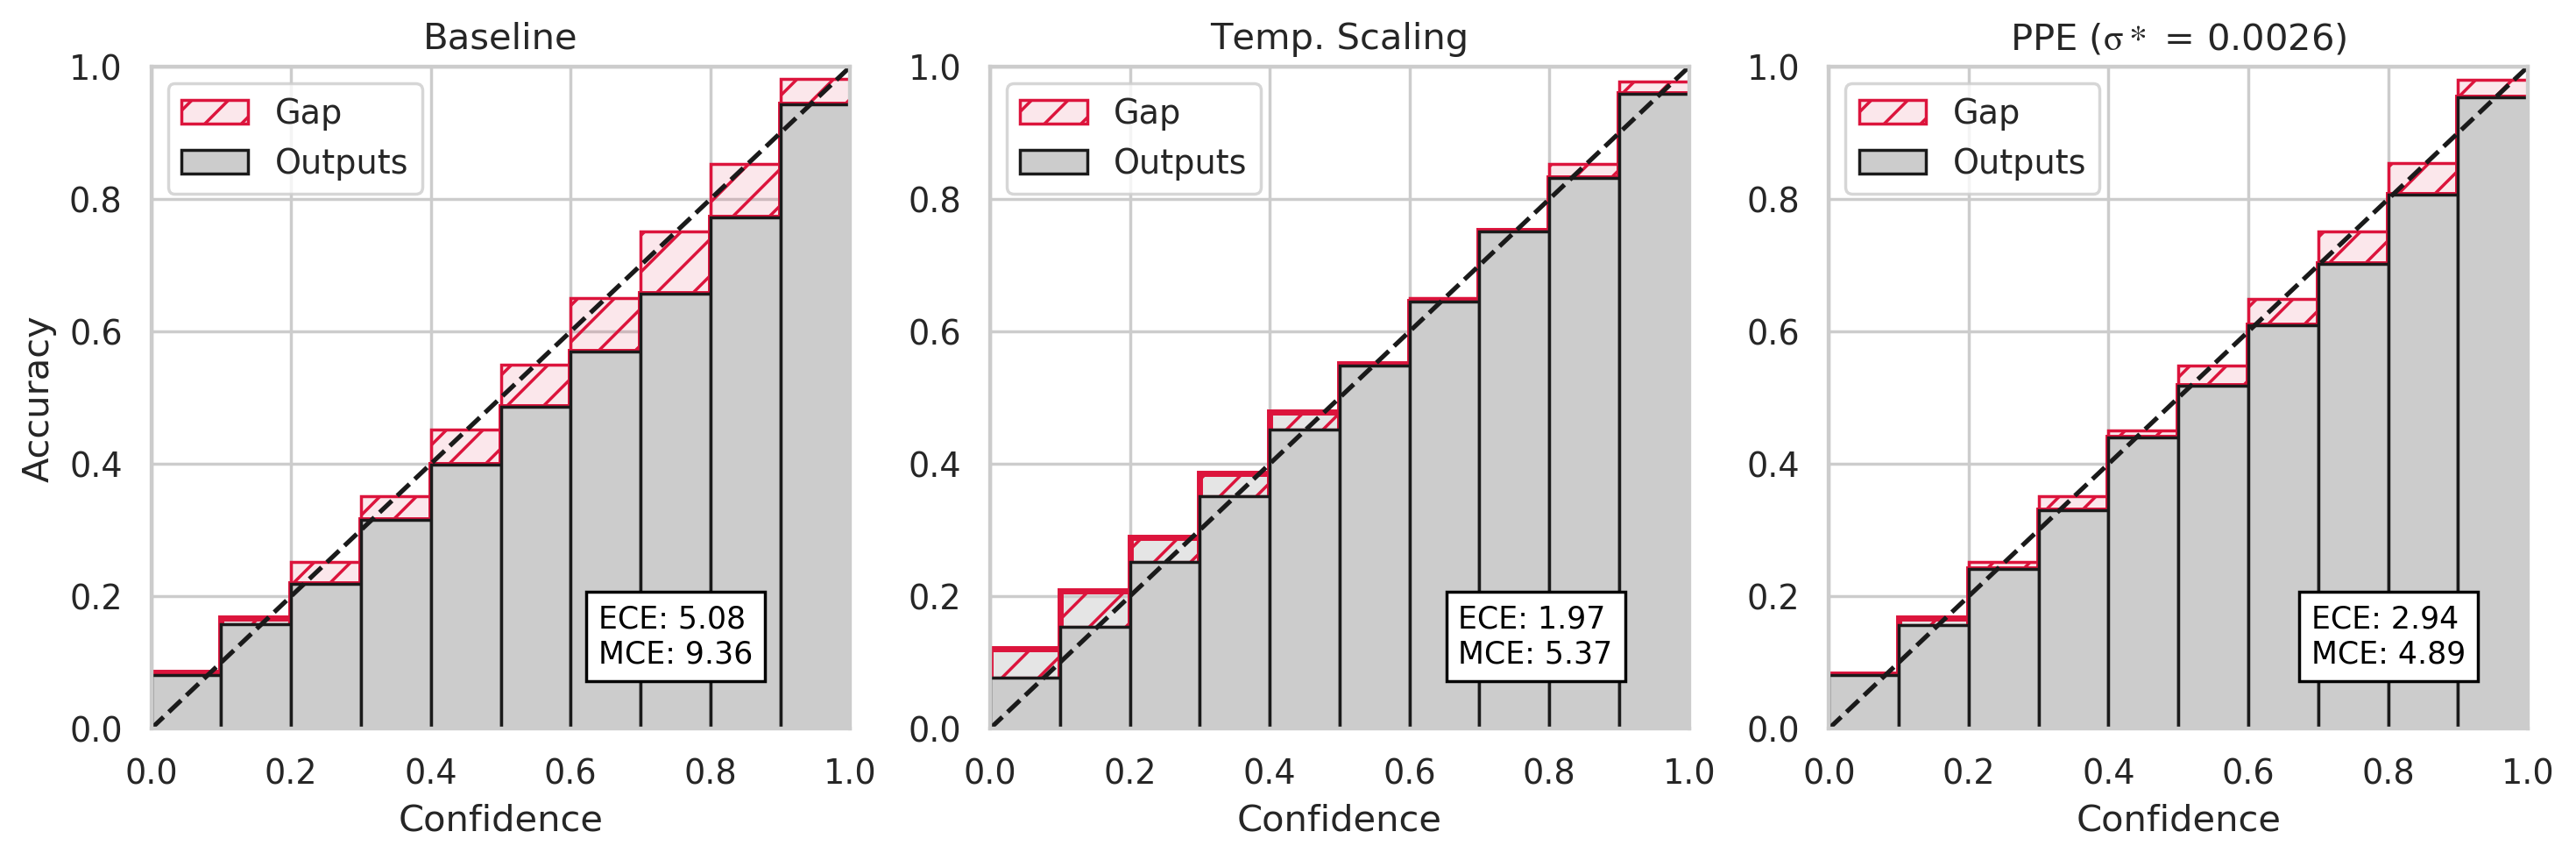

In [27]:
plt.figure(figsize=(14,4), dpi=250)
ax = plt.subplot(131)
plot_confidence(confidence_bl, acc_bl, ax)
ax.set_title('Baseline' )
ax.text(0.64, 0.1, 'ECE: {0:0.2f}\nMCE: {1:0.2f}'.format(ece_bl, mce_bl), color='black',  bbox=dict(facecolor='white', edgecolor='black'))
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy')
ax = plt.subplot(132)
plot_confidence(confidence_temp, acc_temp, ax)
ax.set_title('Temp. Scaling')
ax.text(0.67, 0.1, 'ECE: {0:0.2f}\nMCE: {1:0.2f}'.format(ece_temp, mce_temp), color='black',  bbox=dict(facecolor='white', edgecolor='black'));
ax.set_xlabel('Confidence')
ax = plt.subplot(133)
plot_confidence(confidence_ppe, acc_ppe, ax)
ax.set_title('PPE (' + r'$\rm{\sigma*}$' + ' = {0:.4f})'.format(sigma_optimum))
ax.text(0.69, 0.1, 'ECE: {0:0.2f}\nMCE: {1:0.2f}'.format(ece_ppe, mce_ppe), color='black',  bbox=dict(facecolor='white', edgecolor='black'));
ax.set_xlabel('Confidence')
plt.savefig(os.path.join(output_folder, 'calibration_maps.png'))

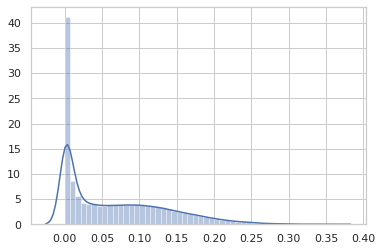

In [28]:
goh = np.zeros((10,45000))
for i in range(45000):
    goh[..., i] = y_pred_ensembles[..., i, y_pred_mean_argmax[i]]
y_pred_std = np.std(goh, axis=0)
sns.distplot(y_pred_std)

In [29]:
def calculate_risk(y_true, y_pred_ensemble, bin_size=0.01):
    risk_thresholds = np.arange(0,0.35 + bin_size, bin_size)
    y_true = np.argmax(y_true, axis=-1)
    risk = y_pred_std
    y_pred_prob_c = np.argmax(np.mean(y_pred_ensemble, axis=0), axis=-1)
    accuracies = np.zeros((len(risk_thresholds, )))
    sum_filtered = 0
    for index, risk_threshold in enumerate(risk_thresholds):
        filtered = np.where((risk_threshold<=risk) & (risk<=risk_threshold+bin_size))[0]
        if len(filtered) > 100:
            accuracies[index] = 1- calculate_error(y_true[filtered], y_pred_prob_c[filtered])
            sum_filtered += len(filtered)
    print(sum_filtered)
    return risk_thresholds, accuracies

In [30]:
def plot_risk(thresholds, accuracy, ax, bin_size=0.01):
    ax.bar(thresholds+bin_size/2, accuracy, fc='white', ec='k', width=bin_size)
    ax.set_xlim([0,0.35])

44724


Text(0, 0.5, 'Accuracy')

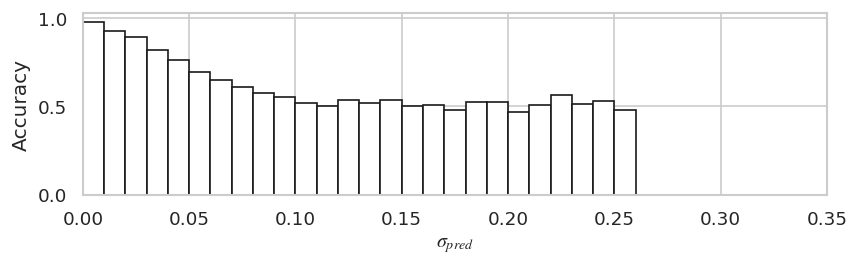

In [31]:
plt.figure(figsize=(8,2), dpi=120)
plt.subplots_adjust(hspace=0.3)
ax = plt.subplot(111)
risk_thresholds, acc_pe = calculate_risk(y_true, y_pred_ensembles)
plot_risk(risk_thresholds, acc_pe, ax)
ax.set_xlabel('$\sigma_{pred}$', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)

In [32]:
correct_cases_top_1 = y_pred_mean_argmax == y_true_argmax
argsorted_y = np.argsort(y_pred_ensemble_mean)[:, -5:]
correct_cases = np.any(argsorted_y.T == y_true.argmax(axis=1), axis=0)

(0, 1)

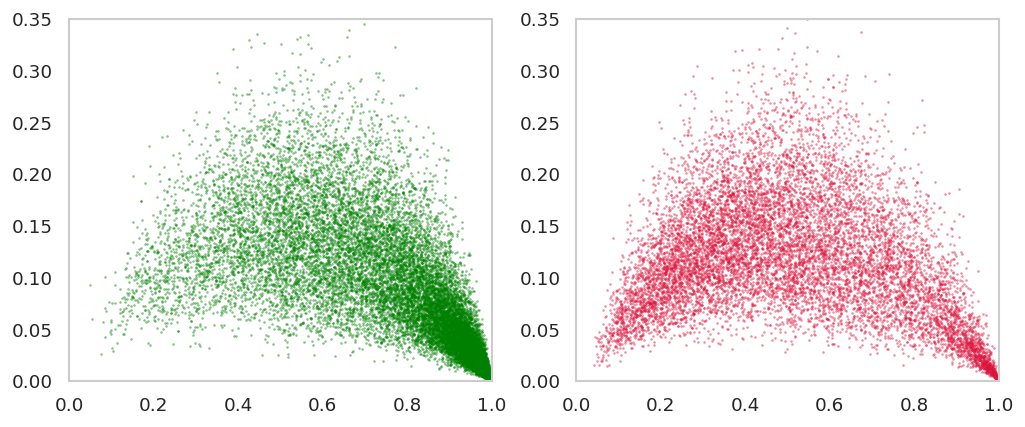

In [33]:
plt.figure(figsize=(10,4), dpi=120)
ax=plt.subplot(121)
ax.scatter(y_pred_mean_amax[correct_cases_top_1], y_pred_std[correct_cases_top_1], s=1, alpha=0.5, marker='.', color='green')
ax.grid()
ax.set_ylim([0, 0.35])
ax.set_xlim([0, 1])
ax=plt.subplot(122)
ax.scatter(y_pred_mean_amax[~correct_cases_top_1], y_pred_std[~correct_cases_top_1], s=1, alpha=0.5, marker='.', color='crimson')
ax.grid()
ax.set_ylim([0, 0.35])
ax.set_xlim([0, 1])

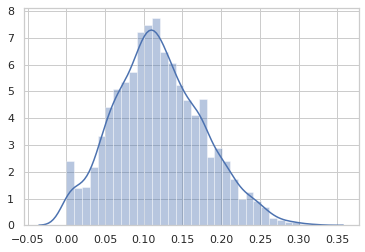

In [34]:
sns.distplot(y_pred_std[~correct_cases])

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


<Figure size 480x480 with 0 Axes>

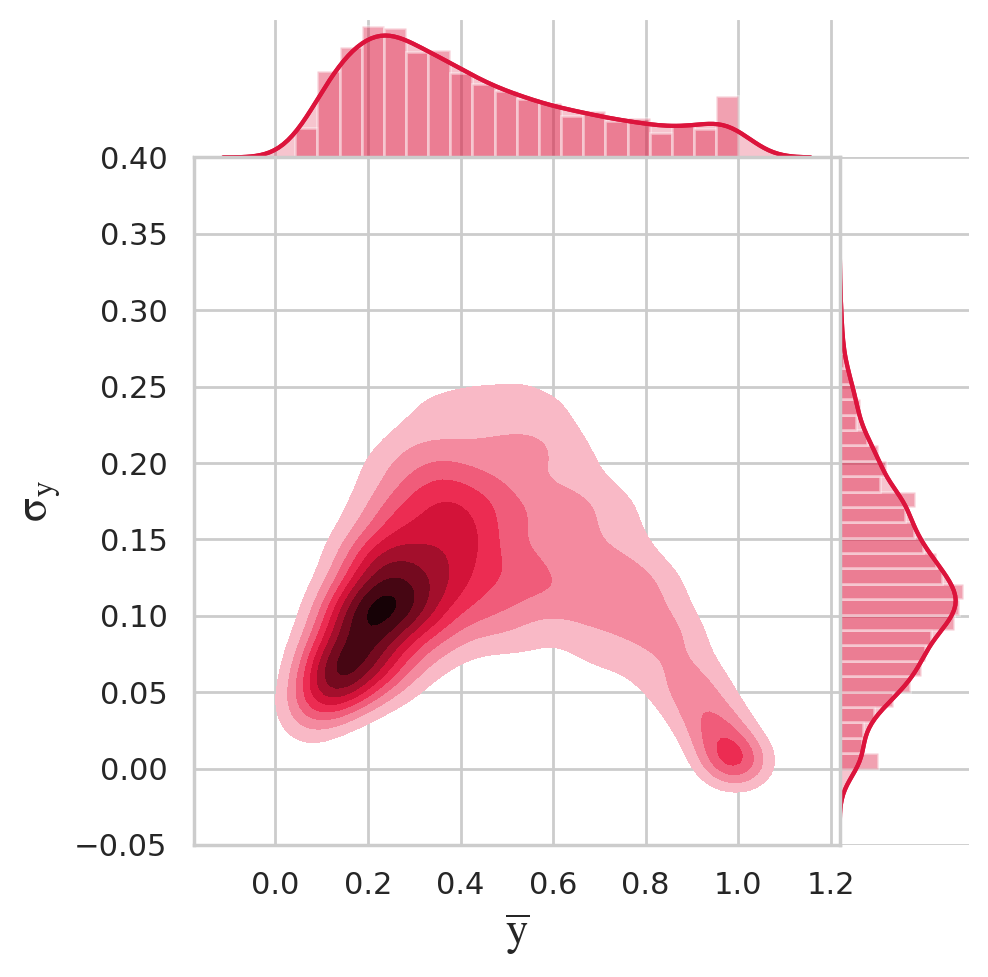

In [35]:
plt.figure(figsize=(4,4), dpi=120)
g = sns.jointplot(y_pred_mean_amax[~correct_cases], y_pred_std[~correct_cases], 
                  kind='kde', color='crimson', space=0, shade_lowest=False, n_levels=10)
sns.distplot(y_pred_mean_amax[~correct_cases], kde=True, color="crimson", ax=g.ax_marg_x)
sns.distplot(y_pred_std[~correct_cases], kde=True, color="crimson", ax=g.ax_marg_y, vertical=True)
g.fig.set_size_inches(5,5)
g.fig.set_dpi(200)
g.set_axis_labels(r"$\rm{\overline{y}}}$", r"$\rm{\sigma_y}$", fontsize=16);
plt.ylim([-0.05,0.4])
# g.ax_joint.collections[0].set_alpha(0)
plt.gcf().subplots_adjust(left=0.2,bottom=0.15)
plt.savefig(os.path.join(output_folder, 'mean_std_incorrect.png'))

<Figure size 480x480 with 0 Axes>

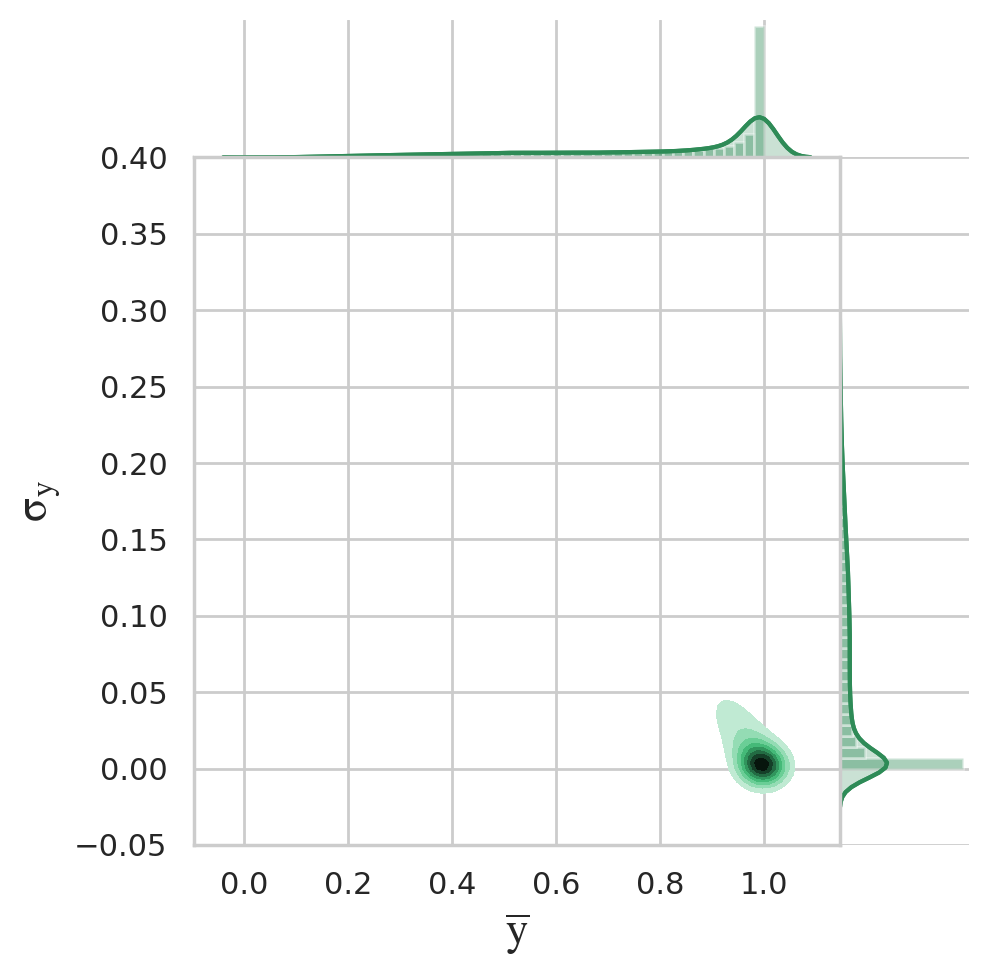

In [36]:
plt.figure(figsize=(4,4), dpi=120)
color = 'mediumseagreen'
color = 'seagreen'
g = sns.jointplot(y_pred_mean_amax[correct_cases], y_pred_std[correct_cases], 
                  kind='kde', color=color, space=0, shade_lowest=False, n_levels=10)
sns.distplot(y_pred_mean_amax[correct_cases], kde=True, color=color, ax=g.ax_marg_x)
sns.distplot(y_pred_std[correct_cases], kde=True, color=color, ax=g.ax_marg_y, vertical=True)
g.fig.set_size_inches(5,5)
g.fig.set_dpi(200)
plt.ylim([-0.05,0.4])
g.set_axis_labels(r"$\rm{\overline{y}}}$", r"$\rm{\sigma_y}$", fontsize=16);
plt.gcf().subplots_adjust(left=0.2,bottom=0.15)
plt.savefig(os.path.join(output_folder, 'mean_std_correct.png'))

In [37]:
print(np.sum(correct_cases))
print(np.sum(~correct_cases))

41421
3579


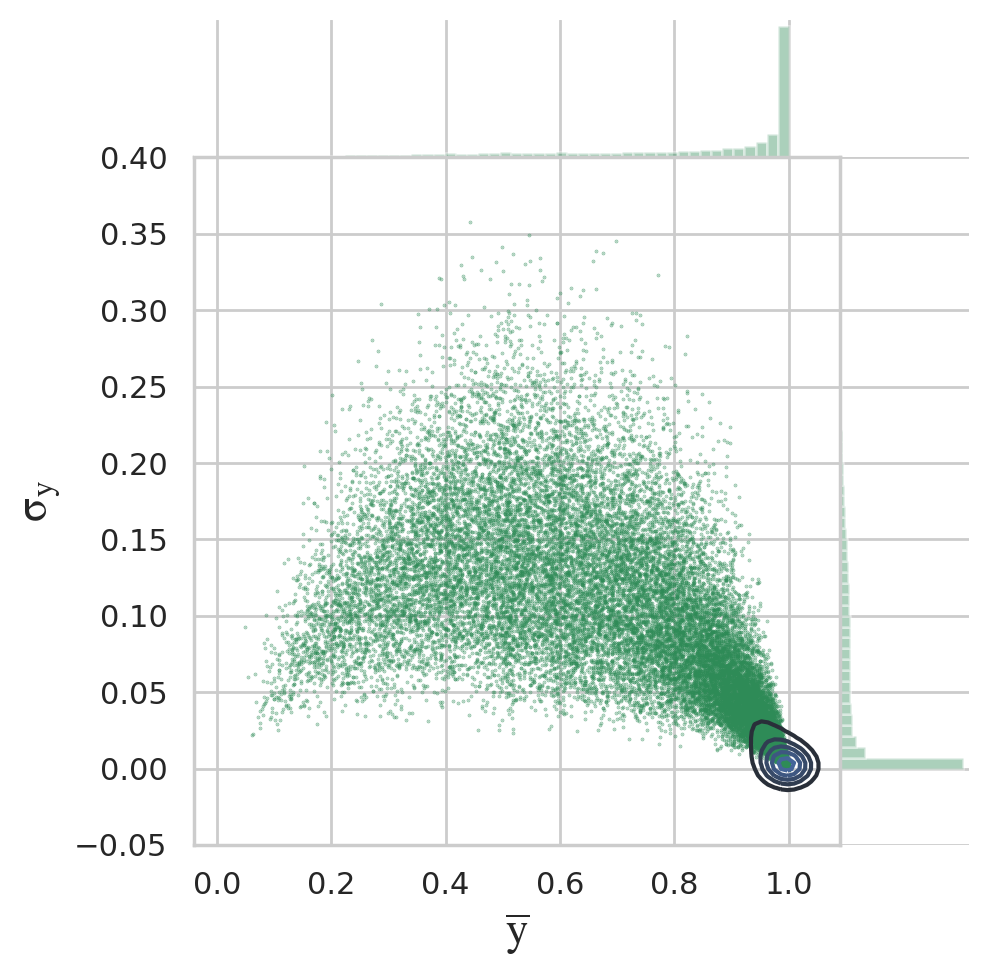

In [38]:
g = sns.jointplot(y_pred_mean_amax[correct_cases], y_pred_std[correct_cases], color="seagreen", space=0,
                   joint_kws={"s": 0.5, "alpha":0.5, "marker":'.'}
                  ).plot_joint(sns.kdeplot, zorder=1, n_levels=6)
g.fig.set_size_inches(5,5)
g.fig.set_dpi(200)
plt.ylim([-0.05,0.4])
g.set_axis_labels(r"$\rm{\overline{y}}}$", r"$\rm{\sigma_y}$", fontsize=16);
plt.gcf().subplots_adjust(left=0.2,bottom=0.15)
plt.savefig(os.path.join(output_folder, 'mean_std_correct_with_scatter.png'))

/home/mehrtash/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'space'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


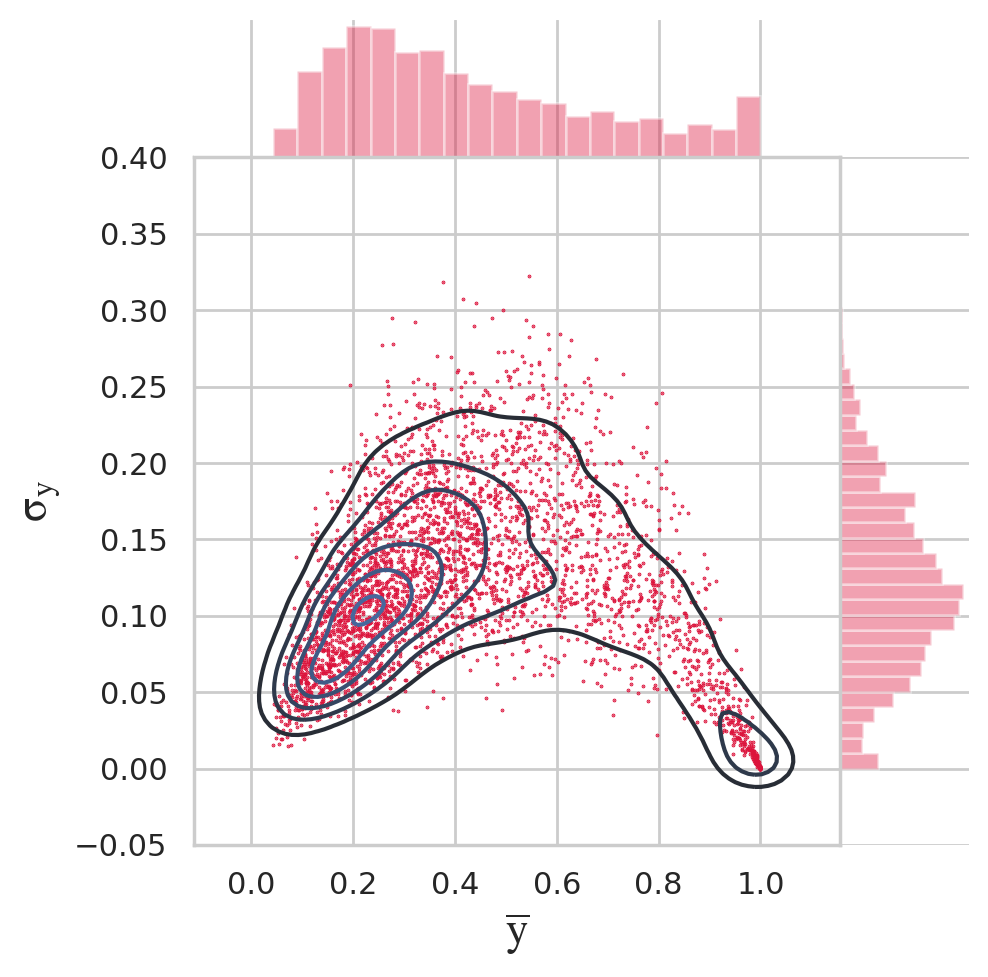

In [39]:
g = sns.jointplot(y_pred_mean_amax[~correct_cases], y_pred_std[~correct_cases], color="crimson", space=0,
                   joint_kws={"s": 0.5, "alpha":1, "marker":'.'},
                  ).plot_joint(sns.kdeplot, zorder=1, n_levels=6, space=0)
g.fig.set_size_inches(5,5)
g.fig.set_dpi(200)
plt.ylim([-0.05,0.4])
g.set_axis_labels(r"$\rm{\overline{y}}}$", r"$\rm{\sigma_y}$", fontsize=16);
plt.gcf().subplots_adjust(left=0.2,bottom=0.15)
plt.savefig(os.path.join(output_folder, 'mean_std_incorrect_with_scatter.png'))

In [40]:
imagenet_classes = pd.read_csv(os.path.join(images_folder, 'keras_ids_to_name.csv'))

In [54]:
condition3 = (y_pred_std>=0.05) &(y_pred_mean_amax>=0.95)
condition3_inx = np.where(condition3)[0]
calculate_error(y_true_argmax[condition3_inx], y_pred_mean_argmax[condition3_inx])
confidently_wrong = np.where((condition3) & ~correct_cases)[0]
print(len(confidently_wrong))

3


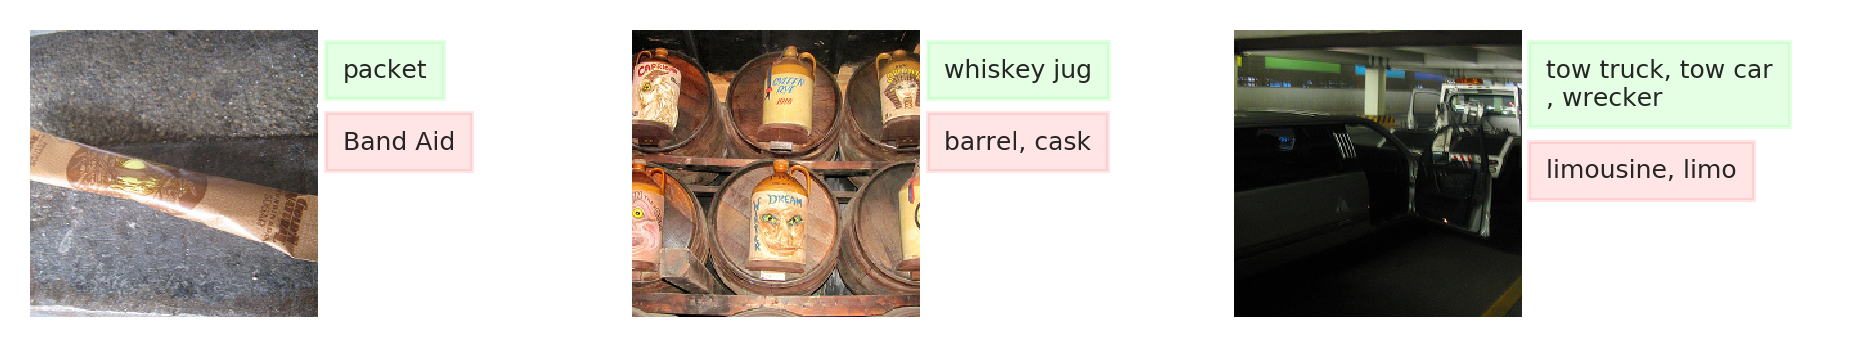

In [55]:
import matplotlib.gridspec as gridspec
import re
for index in range(len(confidently_wrong)):
    grid_no = 2* (index % 32)
    if index % 32 == 0:
        fig = plt.figure(figsize=(8, 8), dpi=300)
        plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
        gs = gridspec.GridSpec(8, 8)
        gs.update(wspace=0.025, hspace=0.05)
    ax = plt.subplot(gs[grid_no])
    ax.imshow(X[confidently_wrong[index]])
    plt.axis('off')
    ax = plt.subplot(gs[grid_no+1])
    true_name = imagenet_classes.loc[y_true_argmax[confidently_wrong[index]],'name'].replace('\n','')
    true_name = re.sub("(.{18})", "\\1\n", true_name, 0, re.DOTALL)
    pred_name = imagenet_classes.loc[y_pred_mean_argmax[confidently_wrong[index]], 'name'].replace('\n','')
    pred_name = re.sub("(.{18})", "\\1\n", pred_name, 0, re.DOTALL)
    text_content = true_name
    ax.text(0.05, 0.9, text_content, size=6, ha="left", va="top", backgroundcolor=(0,1,0,0.1))
    n_lines = text_content.count("\n")
    #
    text_content = pred_name
    ax.text(0.05, 0.65 - n_lines*0.1, text_content, size=6, ha="left", va="top", backgroundcolor=(1,0,0,0.1))
    plt.axis('off')
    if index % 32 == 31:
        plt.savefig(os.path.join(output_folder, 'overconfident_wrong_' + str(index // 32) + '.png'))
plt.savefig(os.path.join(output_folder, 'overconfident_wrong_' + str(index // 32) + '.png'))

In [43]:
#specific_class = np.where(y_true_argmax == 120)[0]
#print(specific_class)
#for i in range(20):
#    random_index = specific_class[np.random.randint(0, len(specific_class), 1)[0]]
#    plt.figure()
#    plt.imshow(X[random_index])

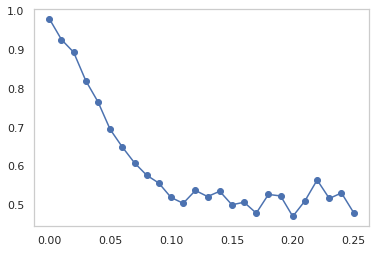

In [44]:
plt.plot(risk_thresholds[np.where(acc_pe>0)], acc_pe[np.where(acc_pe>0)], '-o')
plt.grid()

In [45]:
np.save(os.path.join(image_net_model_folder, 'risk_thresholds.npy'), risk_thresholds)
np.save(os.path.join(image_net_model_folder, 'acc_pe.npy'), acc_pe)